In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('2013_NYC_taxi_sample.csv')

In [2]:
df.head(5)

,pickup_datetime,dropoff_datetime,Passenger_count,Trip_distance,Fare_amount,Tip_amount,Tolls_amount,Total_amount,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,vendor_id
0,2013-10-12 17:23:17,2013-10-12 17:29:03,1,1.29,6.5,1.4,0.0,8.4,-73.978607,40.684574,-73.978622,40.675663,2
1,2013-10-12 17:23:41,2013-10-12 17:39:14,1,3.29,13.5,0.0,0.0,14.0,-73.905167,40.839924,-73.883690,40.880474,2
2,2013-10-12 17:23:52,2013-10-12 17:34:33,1,2.33,10.5,0.0,0.0,11.0,-73.844231,40.721508,-73.852493,40.693714,2
3,2013-10-12 17:23:57,2013-10-12 17:28:55,5,1.42,6.5,0.0,0.0,7.0,-73.951836,40.787243,-73.938934,40.804901,2
4,2013-10-12 17:24:08,2013-10-12 17:34:45,1,2.66,11.0,2.3,0.0,13.8,-73.870262,40.733791,-73.913704,40.746078,2


In [3]:
df.describe()

,Passenger_count,Trip_distance,Fare_amount,Tip_amount,Tolls_amount,Total_amount,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,vendor_id
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,1.682229,3.070055,12.780579,0.909267,0.151650,14.656840,-73.816351,40.717258,-73.782889,40.690510,1.844429
std,1.391625,3.047714,10.189144,2.181773,0.936461,11.476384,2.792346,1.540914,3.231756,1.782829,0.362454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-74.147163,0.000000,-74.286713,0.000000,1.000000
25%,1.000000,1.100000,6.500000,0.000000,0.000000,7.500000,-73.952751,40.743180,-73.960457,40.735764,2.000000
50%,1.000000,2.070000,10.000000,0.000000,0.000000,11.000000,-73.937370,40.775059,-73.937386,40.764511,2.000000
75%,1.000000,4.000000,16.000000,1.000000,0.000000,18.000000,-73.897779,40.809971,-73.892288,40.805477,2.000000
max,9.000000,36.750000,624.000000,160.000000,20.330000,624.500000,0.000000,41.060890,0.000000,41.071342,2.000000


In [4]:
df['vendor_id'].value_counts()

2    29555
1     5445
Name: vendor_id, dtype: int64

### General Steps:
1. Use the pickup_datetime & dropoff_datetime, generate trip_time for each trip.

2. Clean data: 
   - Drop zeros in Trip distance and Total amount. 
   - Drop outliers in features used in the work.
   
 
3. Define Matrix as **Price per mile** and **Price per minute** to evaluate the performance.

4. Use T-test to test the difference between Company 1 and Company 2

5. Use Regressions to identify whether Company 2 is significantly from Company 1 in the defined features. 

#### Create New variable: Time of the trip

In [5]:
import datetime as dt
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['Trip_time']=(df['dropoff_datetime'] - df['pickup_datetime']).astype('timedelta64[m]')

In [6]:
df['Trip_time'].describe()

count    35000.000000
mean        12.843771
std         29.472903
min      -1411.000000
25%          5.000000
50%         10.000000
75%         16.000000
max       1421.000000
Name: Trip_time, dtype: float64

In [7]:
df[df['Trip_time']<=0]['Total_amount'].mean()

12.807915851272014

**Mark**: I am not sure if it is wrong with the data for charging customers with Trip time=0, but in this work I will drop those Trip time<=0

In [8]:
# Roughly Clean data: drop out distance==0 or total amount ==0 or Trip time==0
df_sub= df[(df['Trip_distance']!=0) & (df['Total_amount']!=0) & (df['Trip_time']>0)].copy()

In [9]:
df_sub.describe()

,Passenger_count,Trip_distance,Fare_amount,Tip_amount,Tolls_amount,Total_amount,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,vendor_id,Trip_time
count,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000,32888.000000
mean,1.701472,3.237682,13.013329,0.951693,0.156984,14.951807,-73.870707,40.746430,-73.902476,40.755214,1.856756,13.273626
std,1.412999,3.039782,9.130841,2.038190,0.945650,10.555789,1.954682,1.079110,1.289970,0.712736,0.350327,26.135630
min,1.000000,0.010000,0.000000,0.000000,0.000000,0.010000,-74.075592,0.000000,-74.286713,0.000000,1.000000,1.000000
25%,1.000000,1.230000,7.000000,0.000000,0.000000,8.000000,-73.953255,40.741020,-73.961847,40.734359,2.000000,6.000000
50%,1.000000,2.200000,10.000000,0.000000,0.000000,11.500000,-73.937813,40.775330,-73.938126,40.764782,2.000000,10.000000
75%,1.000000,4.200000,16.500000,1.300000,0.000000,18.500000,-73.898003,40.809426,-73.892159,40.805038,2.000000,16.000000
max,7.000000,36.750000,166.500000,90.000000,20.330000,167.000000,0.000000,40.981766,0.000000,41.071342,2.000000,1421.000000


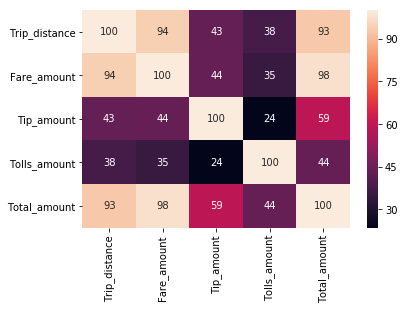

In [10]:
correlations = df_sub.iloc[:,3:8].corr()
sns.heatmap(correlations*100, annot=True, fmt='.0f') 

Exclude extreme long trip

In [11]:
print(df_sub['Total_amount'].quantile(0.99))

# Based on the quantile value above, cut off the total amount at $50 (out of 50 as outliers). 
df_sub = df_sub[df_sub['Total_amount']<50]

53.76040000000008


In [12]:
print(df_sub['Trip_time'].quantile(0.999))

# Based on the quantile value above, cut off the Trip time at 65 min
df_sub = df_sub[df_sub['Trip_time']<65]

65.0


### Create New variable: Price per distance & Price per minute

In [13]:
# Define a new variable dollar_per_distance = Total amount / distance 
df_sub['dollar_per_distance']=df_sub['Total_amount']/df_sub['Trip_distance']
print(df_sub['dollar_per_distance'].quantile(q=0.99))
df_sub = df_sub[df_sub['dollar_per_distance']<df_sub['dollar_per_distance'].quantile(q=0.99)]

16.666666666666664


In [14]:
# Define a new variable dollar_per_minute = Total amount / Time 
df_sub['dollar_per_minute']=df_sub['Total_amount']/df_sub['Trip_time']
print(df_sub['dollar_per_minute'].quantile(q=0.999))
df_sub = df_sub[df_sub['dollar_per_minute']<df_sub['dollar_per_minute'].quantile(q=0.999)]

5.8298333333335295


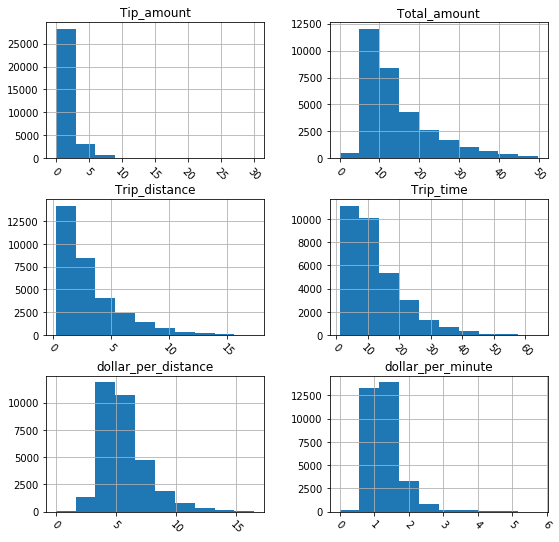

In [15]:
df_sub.iloc[:,[3,5,7,13,14,15]].hist(figsize=(9,9),xrot=-45)
plt.show()

In [16]:
df_sub['vendor_id'].value_counts()

2    27434
1     4576
Name: vendor_id, dtype: int64

### General statistical tests between the two companies with Graphs

Results: t-test shows the Company 1 has **higher price per distance**  rate. Company 2 has **longer trip distance** and **longer trip time** and **Total Amount of the trip**. But no difference in price per minutes.

In [17]:
com1 = df_sub[df_sub['vendor_id']==1]
com2 = df_sub[df_sub['vendor_id']==2]

#### Amount per Distance

Ttest_indResult(statistic=3.312708310346912, pvalue=0.0009294457388427494)
vendor_id
1    5.810072
2    5.697635
Name: dollar_per_distance, dtype: float64


C:\Users\yydab\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Difference between Dollar per Distance')

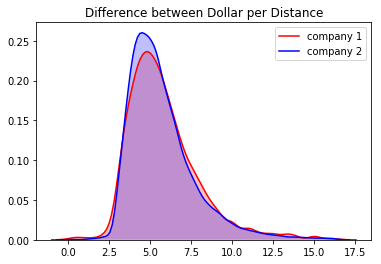

In [18]:
print(stats.ttest_ind(com1['dollar_per_distance'], com2['dollar_per_distance'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['dollar_per_distance'].mean())

ax0 = sns.kdeplot(df_sub['dollar_per_distance'][(df_sub['vendor_id']==1)], 
              shade=True, color="r", label='company 1')
ax0 = sns.kdeplot(df_sub['dollar_per_distance'][(df_sub['vendor_id']==2)], 
              shade=True, color="b", label='company 2')
ax0.set_title("Difference between Dollar per Distance")

#### Amount per Minutes

Ttest_indResult(statistic=0.9072416896124116, pvalue=0.3643147486527085)
vendor_id
1    1.335310
2    1.327755
Name: dollar_per_minute, dtype: float64


Text(0.5, 1.0, 'Difference between Dollar per Minute')

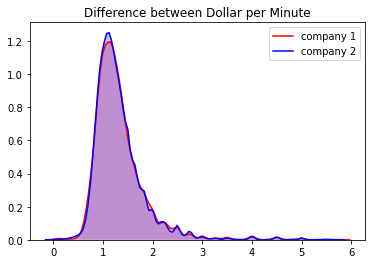

In [19]:
print(stats.ttest_ind(com1['dollar_per_minute'], com2['dollar_per_minute'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['dollar_per_minute'].mean())

ax1 = sns.kdeplot(df_sub['dollar_per_minute'][(df_sub['vendor_id']==1)], 
              shade=True, color="r", label='company 1')
ax1 = sns.kdeplot(df_sub['dollar_per_minute'][(df_sub['vendor_id']==2)], 
              shade=True, color="b", label='company 2')
ax1.set_title("Difference between Dollar per Minute")

In [20]:
# Amount of the trip
print(stats.ttest_ind(com1['Total_amount'], com2['Total_amount'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['Total_amount'].mean())

# Trip Distance
print(stats.ttest_ind(com1['Trip_distance'], com2['Trip_distance'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['Trip_distance'].mean())

# Trip Time
print(stats.ttest_ind(com1['Trip_time'], com2['Trip_time'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['Trip_distance'].mean())

Ttest_indResult(statistic=-3.9791596088447205, pvalue=6.993328813565174e-05)
vendor_id
1    13.861263
2    14.404668
Name: Total_amount, dtype: float64
Ttest_indResult(statistic=-3.037807361238313, pvalue=0.002392898874395472)
vendor_id
1    2.981600
2    3.105278
Name: Trip_distance, dtype: float64
Ttest_indResult(statistic=-2.920386404667453, pvalue=0.00350852205895152)
vendor_id
1    2.981600
2    3.105278
Name: Trip_distance, dtype: float64


In [21]:
print(stats.ttest_ind(com1['Passenger_count'], com2['Passenger_count'], equal_var = False))
print(df_sub.groupby(by=['vendor_id'])['Passenger_count'].mean())

Ttest_indResult(statistic=-38.73818194507485, pvalue=0.0)
vendor_id
1    1.274694
2    1.777247
Name: Passenger_count, dtype: float64


## Linear regression: 

**Equation 1: Total_amount = Company2 (Dummy) + Trip_distance + Time + (Passage number>4(Dummy))**

**Equation 2: Amount_per_Distance = Company2 (Dummy) + Trip_distance + Time + (Passage number>4(Dummy))**

**Equation 3: Amount_per_Minutes = Company2 (Dummy) + Trip_distance + Time + (Passage number>4(Dummy))**

Explain: we want to check whether the coefficient of company 2 is greater than company 1 with control of trip distance and time, which means in general company 2 charge higher than company 1. The variable Passage number>4(Dummy) is an indicator that whether the group of passangers need a larger SUV taxi.

#### Test of Multi-collinearity by VIF (variance inflation factor)

Be careful: **Multi-collinearity** Problme in regressions

In [22]:
# Dummy variable for company 2:
df_sub['comp_dummy'] = df['vendor_id'].map({1: 0, 2: 1})
df_sub['comp_dummy'].mean()

0.8570446735395189

In [23]:
# Dummy variable for Passage number>4:
df_sub['large_car'] = df['Passenger_count']>4
df_sub['large_car'].fillna(0)
df_sub['large_car'].mean()
# df_sub['large_car'] = pd.get_dummies(df['Passenger_count']>4)

0.13398937831927524

In [24]:
# Break into left and right hand side; y and X
y1, X = dmatrices("Total_amount ~ comp_dummy+Trip_distance+Trip_time+large_car", data=df_sub, return_type="dataframe")

# calculate VIF (If VIF>10, seriously collinearity problem, need conduct feature selection)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Fit X to y
result1 = sm.OLS(y1, X).fit()

In [25]:
print(vif)

[8.875695109569765, 1.0261385032856887, 1.0263422500251096, 2.485994292894629, 2.4861346676159393]


**Collinearity**: The collinearity problem is moderate. We can use Trip_distance and Trip_time in the same equation

In [26]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:           Total_amount   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.054e+05
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:56:23   Log-Likelihood:                -72455.
No. Observations:               32010   AIC:                         1.449e+05
Df Residuals:                   32005   BIC:                         1.450e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8961      0.03

In [27]:
# Break into left and right hand side; y and X
y2, X = dmatrices("dollar_per_distance ~ comp_dummy+Trip_distance+Trip_time+large_car", data=df_sub, return_type="dataframe")

# Fit X to y
result2 = sm.OLS(y2, X).fit()
print(result2.summary())

                             OLS Regression Results                            
Dep. Variable:     dollar_per_distance   R-squared:                       0.407
Model:                             OLS   Adj. R-squared:                  0.407
Method:                  Least Squares   F-statistic:                     5500.
Date:                 Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                         16:56:23   Log-Likelihood:                -59737.
No. Observations:                32010   AIC:                         1.195e+05
Df Residuals:                    32005   BIC:                         1.195e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.1769

In [28]:
# Break into left and right hand side; y and X
y3, X = dmatrices("dollar_per_minute ~ comp_dummy+Trip_distance+Trip_time+large_car", data=df_sub, return_type="dataframe")

# Fit X to y
result3 = sm.OLS(y3, X).fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:      dollar_per_minute   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     4290.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:56:23   Log-Likelihood:                -17134.
No. Observations:               32010   AIC:                         3.428e+04
Df Residuals:                   32005   BIC:                         3.432e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.6372      0.00

### Conclusion:
With a focus on variable comp_dummy(whether it is company 2), the regression results show us:
 Company 2 has significantly higher total amount per trip (0.0954, p<0.05) 
 Company 2 has significantly lower amount per distance (-0.0567, p<0.05)
 There is no significant difference in price per minute between the two companies (p=0.787). 

**In conclusion**: 

 Assume the gas price and labor fee are the same for two companies, Company 1 charge higher in Price per mile. If the we care about the matrix "price per mile", then we can conclude Company 1 did a better job based on this database.
 
 
 However, this may lead to fewer customers in the market. If the sample is randomly selected and contains all trips within a certain time period in New York, then we can see Company 2 has a larger market share. If we define:
 
  **Total Profit = Amount per trip * Number of trips -  Variable cost - Fix Cost**
 
 It is highly possible that Company 2, with a little bit sacrifice of profit per trip but won a bigger market, performed better in total profit. 
